# **Amaterasu**
<div>
<img src="https://i0.wp.com/japanthis.com/wp-content/uploads/2020/06/d800055d-c173-425d-a50d-f291a640a781.jpeg?resize=652%2C946&ssl=1" width="350"/>
</div>

Amaterasu is a japanese tokenizer based on an LSTM network. The model architecture is heavily inspired by Yoshiaki Kitagawa and Mamoru Komachi's paper [Long Short-Term Memory for Japanese Word Segmentation](https://aclanthology.org/Y18-1033.pdf), Taishi Ikeda, Hiroyuki Shindo and Yuuji Matsumoto's paper [辞書情報と単語分散表現を組み込んだ
リカレントニューラルネットワークによる日本語単語分割](https://www.anlp.jp/proceedings/annual_meeting/2017/pdf_dir/B6-2.pdf) and and Geewook Kim, Kazuki Fukui, Hidetoshi Shimodaira's 2018 paper [Segmentation-free Compositional n-gram Embedding](https://aclanthology.org/N19-1324.pdf). Additional information taken from Takeshi Arabiki's blog post
[日本語形態素解析の裏側を覗く！MeCab はどのように形態素解析しているか](https://techlife.cookpad.com/entry/2016/05/11/170000) and Taku Kudou's book [形態素解析の理論と実装](https://www.amazon.co.jp/%E5%BD%A2%E6%85%8B%E7%B4%A0%E8%A7%A3%E6%9E%90%E3%81%AE%E7%90%86%E8%AB%96%E3%81%A8%E5%AE%9F%E8%A3%85-%E5%AE%9F%E8%B7%B5%E3%83%BB%E8%87%AA%E7%84%B6%E8%A8%80%E8%AA%9E%E5%87%A6%E7%90%86%E3%82%B7%E3%83%AA%E3%83%BC%E3%82%BA-%E5%B7%A5%E8%97%A4-%E6%8B%93/dp/4764905779).

*Built for the final project of LING498 at Concordia University. \\
Fall 2024, Etienne Plante (40236785)*

## Data preparation
Let's first import the necessary modules.

In [ ]:
!pip install bcolz-zipline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 103.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split

import nltk
from nltk.corpus import knbc, jeita

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import seaborn as sns
import numpy as np

import bcolz
import pickle

import time
import random
import itertools
import re
import math
from collections import defaultdict
import os

For reproducibility across executions, let's set up the random seed

In [ ]:
_SEED: int = 42
_SET_SEED: bool = False

if(_SET_SEED):
  random.seed(_SEED)
  np.random.seed(_SEED)
  torch.manual_seed(_SEED)
  torch.cuda.manual_seed(_SEED)
  torch.backends.cudnn.deterministic = True

Next we load the corpora. For Japanese, NLTK offers both JEITA and KNBC. JEITA is much larger comprising 163,986 tagged sentences, compared to 4186 for KNBC. For faster iterative development however, both will be imported here and KNBC used mostly in the early stages of development, keeping JEITA for the final iterations. It will also be great to understand the effect of corpus size (which in this case affects learnable parameter count) on the final model accuracy.

In [ ]:
nltk.download('jeita')
nltk.download('knbc')

jeita = nltk.corpus.jeita.sents()
knbc = nltk.corpus.knbc.sents()

print(f'JEITA sample sentence: {jeita[0]}')
print(f'KNBC sample sentence: {knbc[0]}')

JEITA sample sentence: ['\u3000', '新潟', 'の', '停車場', 'を', '出る', 'と', '列車', 'の', '箱', 'から', 'まけ', '出さ', 'れ', 'た', '樣', 'に', '人々', 'は', 'ぞ', 'ろ', '／', '＼', 'と', '一方', 'へ', '向い', 'て', '行く', '。', '其', 'あと', 'へ', '跟', 'い', 'て', '行く', 'と', 'すぐ', 'に', '長大', 'な', '木橋', 'が', 'ある', '。', '橋', 'へ', 'か', 'ゝ', 'つて', 'ぶら', '／', '＼', 'と', '辿', 'つて', '來', 'る', 'と', '古', '傘', 'を', '手', 'に', '提げ', 'た', '若者', 'が', '余', 'の', '側', 'へ', '寄', 'つて', '丁寧', 'な', '辭', '儀', 'を', 'し', 'て', '新潟', 'は', 'どちら', 'へ', 'お', '泊り', 'です', 'か', 'と', '問う', 'た', '。', '彼', 'は', '宿', '引', 'で', 'あつ', 'た', 'の', 'だ', '。', '何', '處', 'といふ', 'こと', 'は', 'ない', 'が', '郵便', '局', 'へ', '用', 'が', 'ある', 'の', 'だ', 'から', '其', '方', 'へ', '行か', 'ね', 'ば', 'なら', 'ぬ', 'と', '斷', 'る', '積り', 'で', 'いふ', 'と', '、', '局', 'なら', 'ば', 'すぐ', '手前', 'の', 'うし', 'ろ', 'に', '當', 'つて', '居り', 'ます', '、', '手前', 'に', 'は', '電話', 'も', 'あり', 'ます', 'スケ', 'に', '佐渡', 'の', '汽船', 'へ', 'お', '差', '支', 'を', '掛ける', 'やう', 'な', 'こと', 'は', '致し', 'ませ', 'ん', 'から', '泊', 'つて', '下され', 'とい', 'つた

[nltk_data] Downloading package jeita to /root/nltk_data...
[nltk_data]   Package jeita is already up-to-date!
[nltk_data] Downloading package knbc to /root/nltk_data...
[nltk_data]   Package knbc is already up-to-date!


These corpora contain only arrays of words. The model however expects arrays of characters that shall be tagged such that $\hat{y}:V \mapsto P$ and $V$ represents the set of unicode characters and $P=\{B,I,E,S\}$ where $B,I,E$ and $S$ represent characters at the beginning, inside, end of a word or single character words respectively.

Let's then reformat the corpora accordingly and add the necessary labels.

In [ ]:
def reformat_knbc():
  tagged_corpus = []

  for sentence in knbc:
    tagged_sentence = {'characters': [], 'labels': []}

    for word in sentence:
      for position, char in enumerate(word):
        tagged_sentence['characters'].append(char)
        if(len(word) == 1):
          tagged_sentence['labels'].append('S')
        elif(position == 0):
          tagged_sentence['labels'].append('B')
        elif(position == len(word) - 1):
          tagged_sentence['labels'].append('E')
        else:
          tagged_sentence['labels'].append('I')

    tagged_corpus.append(tagged_sentence)

  return tagged_corpus

def reformat_jeita():
  tagged_corpus = []

  for sentence in jeita:
    tagged_sentence = {'characters': [], 'labels': []}

    for word in sentence:
      for position, char in enumerate(word):
        tagged_sentence['characters'].append(char)
        if(len(word) == 1):
          tagged_sentence['labels'].append('S')
        elif(position == 0):
          tagged_sentence['labels'].append('B')
        elif(position == len(word) - 1):
          tagged_sentence['labels'].append('E')
        else:
          tagged_sentence['labels'].append('I')

    tagged_corpus.append(tagged_sentence)

  return tagged_corpus

In [ ]:
knbc = reformat_knbc()
print("KNBC: ", knbc[0])

jeita = reformat_jeita()
print("JEITA: ", jeita[0])

KNBC:  {'characters': ['［', '携', '帯', '電', '話', '］', 'プ', 'リ', 'ペ', 'イ', 'ド', 'カ', 'ー', 'ド', '携', '帯', '布', '教', '。'], 'labels': ['S', 'B', 'E', 'B', 'E', 'S', 'B', 'I', 'I', 'I', 'E', 'B', 'I', 'E', 'B', 'E', 'B', 'E', 'S']}
JEITA:  {'characters': ['\u3000', '新', '潟', 'の', '停', '車', '場', 'を', '出', 'る', 'と', '列', '車', 'の', '箱', 'か', 'ら', 'ま', 'け', '出', 'さ', 'れ', 'た', '樣', 'に', '人', '々', 'は', 'ぞ', 'ろ', '／', '＼', 'と', '一', '方', 'へ', '向', 'い', 'て', '行', 'く', '。', '其', 'あ', 'と', 'へ', '跟', 'い', 'て', '行', 'く', 'と', 'す', 'ぐ', 'に', '長', '大', 'な', '木', '橋', 'が', 'あ', 'る', '。', '橋', 'へ', 'か', 'ゝ', 'つ', 'て', 'ぶ', 'ら', '／', '＼', 'と', '辿', 'つ', 'て', '來', 'る', 'と', '古', '傘', 'を', '手', 'に', '提', 'げ', 'た', '若', '者', 'が', '余', 'の', '側', 'へ', '寄', 'つ', 'て', '丁', '寧', 'な', '辭', '儀', 'を', 'し', 'て', '新', '潟', 'は', 'ど', 'ち', 'ら', 'へ', 'お', '泊', 'り', 'で', 'す', 'か', 'と', '問', 'う', 'た', '。', '彼', 'は', '宿', '引', 'で', 'あ', 'つ', 'た', 'の', 'だ', '。', '何', '處', 'と', 'い', 'ふ', 'こ', 'と', 'は', 'な', 'い', 'が', '郵', '便', 

In [ ]:
# Change this to select which dataset to use going forward
learning_corpus = knbc

Let's split the dataset into training, validation and testing subsets in a 8:1:1 random distribution

In [ ]:
train_data, valid_data, test_data = random_split(learning_corpus, [0.8, 0.1, 0.1])
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 3349
Number of validation examples: 419
Number of testing examples: 418


Let us now create a listing of unique features and labels found in the dataset. It will be used to one-hot encode the characters that will be passed on as input to the model.

Additionally, in order for the training time to stay in a reasonable range, let's only consider characters that appear at least twice. Characters of which only a single instance could be found will be added as `<unk>`.

Finally, let's also add a `<pad>` token to pad sentences passed on to the model such that all sentences present in a given batch are of the same size $n$.

In [ ]:
minimum_token_frequency = 2
unk_token = '<unk>'
pad_token = '<pad>'

feature_counts = defaultdict(int)
label_counts = defaultdict(int)

for sentence in learning_corpus:
  for char, label in zip(sentence['characters'], sentence['labels']):
    feature_counts[char.lower()] += 1
    label_counts[label] += 1

feature_list = [(pad_token, 0), (unk_token, 0)]
label_list = [(pad_token, 0)]

for feature, count in feature_counts.items():
  if(count >= minimum_token_frequency):
    feature_list.append((feature, count))
  else:
    feature_list[1] = (unk_token, feature_list[1][1] + 1)

for label, count in label_counts.items():
  label_list.append((label, count))

print(f"Amount of unique features: {len(feature_list)}\n")
print(f"Feature list: {feature_list}")
print(f"Label list: {label_list}")

Amount of unique features: 1616

Feature list: [('<pad>', 0), ('<unk>', 359), ('［', 253), ('携', 409), ('帯', 414), ('電', 399), ('話', 404), ('］', 253), ('プ', 115), ('リ', 171), ('ペ', 34), ('イ', 336), ('ド', 157), ('カ', 192), ('ー', 1242), ('布', 6), ('教', 22), ('。', 3183), ('月', 54), ('１', 248), ('５', 82), ('０', 307), ('円', 82), ('〜', 60), ('２', 154), ('の', 4041), ('現', 66), ('状', 34), ('持', 129), ('か', 2112), ('、', 3183), ('３', 124), ('超', 12), ('で', 2817), ('フ', 163), ('ツ', 100), ('ウ', 50), ('ユ', 8), ('ザ', 29), ('仲', 10), ('間', 208), ('入', 184), ('り', 1244), ('を', 1618), ('す', 1368), ('る', 2527), ('結', 58), ('局', 35), ('こ', 1353), ('よ', 612), ('う', 1687), ('な', 2973), ('論', 11), ('に', 2901), ('落', 31), ('ち', 440), ('着', 73), ('き', 859), ('ま', 1479), ('し', 2699), ('た', 2610), ('確', 32), ('は', 2414), ('い', 4513), ('く', 1146), ('つ', 456), ('弱', 10), ('点', 42), ('が', 2360), ('あ', 1047), ('ｗ', 69), ('ｅ', 88), ('ｂ', 24), ('使', 172), ('え', 508), ('通', 158), ('料', 137), ('や', 521), ('け', 611), ('高

To facilitate data manipulation, let's create a two functions to retrieve the index of a given feature or label within the list

In [ ]:
def get_feature_index(feature):
  for index, item in enumerate(feature_list):
    if(item[0] == feature):
      return index

  return -1

def get_label_index(label):
  for index, item in enumerate(label_list):
    if(item[0] == label):
      return index

  return -1

assert '今' == feature_list[get_feature_index('今')][0]
assert 'B' == label_list[get_label_index('B')][0]

As proposed by *Kitagawa & Komachi (2018)*, character type embeddings and character-based $n$-gram embeddings can be used such that each character vector $c_t$ subsequently passed as input to the network can be represented as $c_t = l_t ⊕ e_t$ where $l_t = l_{[t:t]} \oplus l_{[t:t+1]} \oplus l_{[t:t+2]}$ and $e_t = e_{[t:t]} \oplus e_{[t:t+1]} \oplus e_{[t:t+2]}$
to increase the accuracy of the model.

Let's firstly load n-gram embeddings for all $n$-grams of $1 \leq n \leq 3$. These embeddings were trained using [the following model](https://github.com/kdrl/SCNE) such that each n-gram embedding $v_c$ belongs to the 200-dimensional vector space $\mathbb{R}^{200}$.

In [ ]:
dimensionality = 200

Let's then create the character type embeddings. These will represented as one-hot vectors of length $6+6^2+6^3=258$.

In [ ]:
character_type_embeddings = defaultdict(int)

# Unigrams
character_type_embeddings['hiragana'] = 0
character_type_embeddings['katakana'] = 1
character_type_embeddings['kanji'] = 2
character_type_embeddings['romaji'] = 3
character_type_embeddings['digit'] = 4
character_type_embeddings['other'] = 5

bigrams = list(itertools.product(character_type_embeddings, repeat=2))
trigrams = list(itertools.product(character_type_embeddings, repeat=3))

for bigram in bigrams:
  character_type_embeddings[bigram[0] + bigram[1]] = len(character_type_embeddings)
for trigram in trigrams:
  character_type_embeddings[trigram[0] + trigram[1] + trigram[2]] = len(character_type_embeddings)

print(len(character_type_embeddings), " different character type combinations")

258  different character type combinations


The following function returns a given character's character type.

In [ ]:
def get_character_type(char):
    if re.match(u'[ぁ-ん]', char):
        return 'hiragana'
    elif re.match(u'[ァ-ン]', char):
        return 'katakana'
    elif re.match(u'[一-龥]', char):
        return 'kanji'
    elif re.match(u'[A-Za-z]', char):
        return 'romaji'
    elif re.match(u'[0-9０-９]', char):
        return 'digit'
    else:
        return 'other'

Let's now import n-gram embeddings that will be used as input to the model. These were generated in advance using the method proposed by Geewook Kim et al. Given the amount of vectors and their size, this cell will take a considerable amount of time to execute.

In [ ]:
!mkdir -p ngram_embeddings/

ngrams = []
idx = 0
ngram2idx = {}
vectors = bcolz.carray(np.zeros(1), rootdir='ngram_embeddings/200D.dat', mode='w')

embeddings_path = '/content/drive/MyDrive/Colab Notebooks/ngram_embeddings/WNE.6G.200d'

with open(embeddings_path, 'rb') as f:
  next(f) # Skip the matrix size indicator
  for l in f:
    if idx == 100000:
      break

    line = l.decode().split()

    # For some reason the embeddings file contains malformed lines sometimes
    if len(line) != 200 + 1:
      continue

    word = line[0]
    ngrams.append(word)
    ngram2idx[word] = idx

    idx += 1
    vect = np.array(line[1:]).astype(float)
    vectors.append(vect)

vectors = bcolz.carray(vectors[1:].reshape((100000, 200)), rootdir='ngram_embeddings/200D.dat', mode='w')
vectors.flush()
pickle.dump(ngrams, open('200D.pkl', 'wb'))
pickle.dump(ngram2idx, open('200D_idx.pkl', 'wb'))

vectors = bcolz.open('ngram_embeddings/200D.dat')[:]
ngrams = pickle.load(open('200D.pkl', 'rb'))
ngram2idx = pickle.load(open('200D_idx.pkl', 'rb'))

embeddings = {n: vectors[ngram2idx[n]] for n in ngrams}

In [ ]:
print(embeddings["証明"])

[-1.75288e-01 -4.28149e-01 -2.05106e-01  1.46353e-01 -2.51344e-01
  5.00552e-01 -6.41186e-02 -2.92666e-01  2.13828e-01 -3.52036e-02
 -1.91263e-01  1.74237e-01 -3.28140e-01  1.27081e-01  2.14673e-01
  4.04059e-01  2.56040e-01 -1.17205e-02  3.92173e-01 -1.47059e-01
 -3.04494e-01  7.32812e-02  7.23629e-02 -4.28052e-01 -3.82282e-02
 -1.36838e-01  1.71369e-01 -4.93962e-01 -8.49337e-01 -3.72339e-01
  2.16686e-02  6.10868e-02 -1.04891e-04 -1.28884e-01 -1.46886e-01
  7.68731e-02 -4.37185e-01 -1.07536e-01 -1.67121e-01 -2.94036e-01
 -2.81623e-01  3.37885e-01  3.83203e-01 -3.28798e-01 -9.33719e-02
 -2.80091e-01  9.69930e-02  4.20532e-01  1.16286e-01 -6.25251e-01
  7.19712e-02 -1.73338e-01  2.68606e-01 -2.83325e-01 -1.18404e-03
  6.98669e-01  7.13069e-01  5.11606e-01  3.77821e-02  1.10851e-01
 -1.10137e-01 -3.05013e-01  9.20347e-02  3.60339e-01 -7.27794e-02
 -1.86316e-01  1.33048e-01  5.54482e-01 -4.76474e-01 -5.29388e-01
 -1.13194e-01  7.30915e-02  9.24315e-02 -5.10140e-01  4.77103e-02
  2.66952e

Now that we have every element that make up each character vector, let's create a function that will generate said vector from a given sentence.

In [ ]:
from decimal import Decimal

window_size = 3 # This should not be changed for now as other parts of the code will have to be changed as well

class NGram:
  def __init__(self, n, characters, character_types):
    self.n = n
    self.characters = characters
    self.character_types = character_types

  def __str__(self):
    return f"{self.characters}.{list(character_type_embeddings.keys())[list(character_type_embeddings.values()).index(self.character_types)]}"

  def to_one_hot_vector(self):
    character_embedding = np.zeros(len(feature_list) * self.n)
    for idx, character in enumerate(self.characters):
      character_embedding[get_feature_index(character) + idx * len(feature_list)] = 1

    character_type_embedding = np.zeros(len(character_type_embeddings))
    character_type_embedding[self.character_types] = 1

    return np.concatenate((character_embedding, character_type_embedding))

  def get_embedding(self):
    ngram_str = ''.join(self.characters)

    ngram_embedding = np.zeros(dimensionality)
    if ngram_str in embeddings:
      ngram_embedding = np.array([Decimal(x) for x in embeddings[ngram_str]])

    return ngram_embedding

class CharacterVector:
  def __init__(self, unigram, bigram, trigram):
    self.unigram = unigram
    self.bigram = bigram
    self.trigram = trigram

  def __str__(self):
    return f"Unigram: {self.unigram} | Bigram: {self.bigram} | Trigram: {self.trigram}"

  def to_one_hot_vector(self):
    return np.concatenate((self.unigram.to_one_hot_vector(), self.bigram.to_one_hot_vector(), self.trigram.to_one_hot_vector()))

  def get_character_type_embeddings(self, characters):
    embedding_types = {"hiragana": 0, "katakana": 1, "kanji": 2, "romaji": 3, "digit": 4, "other": 5}
    embeddings = np.zeros(len(characters) * len(embedding_types))
    for i, character in enumerate(characters):
      embeddings[embedding_types[get_character_type(character)] + len(embedding_types) * i] = 1

    return embeddings

  def get_embeddings(self):
    character_type_embeddings = {"hiragana": 0, "katakana": 1, "kanji": 2, "romaji": 3, "digit": 4, "other": 5}
    characters = self.trigram.characters
    return np.concatenate((self.unigram.get_embedding(),
                           self.bigram.get_embedding(),
                           self.trigram.get_embedding(),
                           self.get_character_type_embeddings(characters)))


def generate_character_vectors(sentence):
  vector_count = len(sentence)

  character_vector = np.empty(shape=vector_count, dtype=CharacterVector)
  for t in range(0, vector_count):
    characters = sentence[t:t+window_size]

    character_1 = characters[0] if len(characters) > 0 else '<pad>'
    character_2 = characters[1] if len(characters) > 1 else '<pad>'
    character_3 = characters[2] if len(characters) > 2 else '<pad>'

    character_type_1 = get_character_type(character_1)
    character_type_2 = get_character_type(character_2)
    character_type_3 = get_character_type(character_3)

    unigram = NGram(1, [character_1], character_type_embeddings[character_type_1])
    bigram = NGram(2, [character_1, character_2], character_type_embeddings[character_type_1 + character_type_2])
    trigram = NGram(3, [character_1, character_2, character_3], character_type_embeddings[character_type_1 + character_type_2 + character_type_3])

    character_vector[t] = CharacterVector(unigram, bigram, trigram)

  return character_vector

def generate_label_vectors(labels):
  label_vectors = []

  for label in labels:
    label_vector = np.zeros(len(label_list))
    label_vector[get_label_index(label)] = 1
    label_vectors.append(label_vector)

  return label_vectors

v = generate_character_vectors(['最', '後'])
for idx, vec in enumerate(v):
  print(f"n-grams at t={idx}: ", vec)

print(v[0].get_embeddings().shape)

n-grams at t=0:  Unigram: ['最'].kanji | Bigram: ['最', '後'].kanjikanji | Trigram: ['最', '後', '<pad>'].kanjikanjiother
n-grams at t=1:  Unigram: ['後'].kanji | Bigram: ['後', '<pad>'].kanjiother | Trigram: ['後', '<pad>', '<pad>'].kanjiotherother
(618,)


Finally, let's create data loaders to generate batches for each subset of the dataset.

In [ ]:
batch_size = 128
n_epoch = 15
device = torch.device('cuda') if torch.cuda and torch.cuda.is_available() else torch.device('cpu')

def collate_fn(batch):
  max_sentence_length = max([len(sentence['characters']) for sentence in batch])
  padded_characters = []
  padded_labels = []

  for sentence in batch:
    characters = sentence['characters']
    labels = sentence['labels']

    padded_sentence = characters + [pad_token] * (max_sentence_length - len(characters))
    padded_character_vectors = generate_character_vectors(padded_sentence)

    character_vector_embeddings = []
    for character_vector in padded_character_vectors:
      character_vector_embeddings.append(character_vector.get_embeddings())

    # one_hot_character_vectors = []
    # for character_vector in padded_character_vectors:
    #   one_hot = character_vector.to_one_hot_vector()
    #   one_hot_character_vectors.append(one_hot)

    padded_characters.append(character_vector_embeddings)

    padded_sentence_labels = labels + [pad_token] * (max_sentence_length - len(labels))
    padded_labels.append(generate_label_vectors(padded_sentence_labels))

  return torch.tensor(padded_characters, dtype=torch.float32).to(device), torch.tensor(padded_labels, dtype=torch.float32).to(device)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
validate_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=collate_fn)

In [ ]:
batch = next(iter(train_loader))
batch[0].shape, batch[1].shape

(torch.Size([64, 227, 618]), torch.Size([64, 227, 5]))

# Model Creation and Training
The model used by Amaterasu is described in detail in the following diagram ![Capture.PNG](https://drive.google.com/uc?export=view&id=1G7nk2NEBB_yGUsv55ulB91RtzKFfExZO)

In [ ]:
class Amaterasu(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout_rate):
    super().__init__()

    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout_rate if n_layers > 1 else 0)
    self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
    self.dropout = nn.Dropout(dropout_rate)
    self.log_softmax = nn.LogSoftmax(dim=1)

  def forward(self, text):
    outputs, _ = self.lstm(text)
    predictions = self.log_softmax(self.fc(self.dropout(outputs)))

    return predictions

Let's now set the hyperparameters and the loss function.
Since this is a classification problem, cross entropy is the most appropriate.
As for the optimizer, (Kitagawa, Komachi, 2018) proposed the use of Adagrad which I find extremely odd given the serious drawbacks that come with its use in real life scenarios. I have found better results using Adam or RMSProp.

In [ ]:
embedding_dim = 200
input_dim = embedding_dim * window_size + 6 * window_size
hidden_dim = 128
output_dim = len(label_list)
n_layers = 2
bidirectional = True
dropout_rate = 0.4
learning_rate = 0.1

model = Amaterasu(input_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout_rate)
model = model.to(device)

# optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_loader), epochs=n_epoch)

criterion = nn.CrossEntropyLoss().to(device)

model, criterion

(Amaterasu(
   (lstm): LSTM(618, 128, num_layers=2, dropout=0.4, bidirectional=True)
   (fc): Linear(in_features=256, out_features=5, bias=True)
   (dropout): Dropout(p=0.4, inplace=False)
   (log_softmax): LogSoftmax(dim=1)
 ),
 CrossEntropyLoss())

Let's initialize the weights with a normal distribution with $\mu=0$ and $\sigma=0.1$

In [ ]:
def initialize_weights(model):
  for name, param in model.named_parameters():
    nn.init.normal_(param.data, mean=0, std=0.1)

initialize_weights(model)

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} learnable parameters')

The model has 1,162,501 learnable parameters


The following method calculates the model accuracy accross an entire epoch.

In [ ]:
def categorical_accuracy(predictions, labels):
  max_preds = predictions.argmax(dim = 1, keepdim = True)

  correct_count = 0
  for idx, prediction in enumerate(max_preds):
    if(labels[idx][prediction.item()] == 1 and labels[idx][0] != 1):
      correct_count += 1

  non_labels = sum(label[0] != 1 for label in labels)

  return correct_count / non_labels

In [ ]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))

  return elapsed_mins, elapsed_secs

def display_epoch_status(i, start_time, batch_length, epoch_number, mode):
  epoch_mins, epoch_secs = epoch_time(start_time, time.time())
  progress = (i+1) / batch_length
  progress_bar_fill = math.ceil(20 * ((i+1)/batch_length))
  print(f'\rEpoch: {epoch_number+1:02}/{n_epoch} | Epoch Time: {epoch_mins}m {epoch_secs}s | (Currently {mode}) ', end="")
  print(f"[{'=' * progress_bar_fill}{' ' * (20 - progress_bar_fill)}] {progress * 100:.2f}%", end="")

In [ ]:
def train(loader, start_time, epoch, batch_length):
  epoch_loss = 0
  epoch_accuracy = 0

  model.train()

  for i, (sentence, labels) in enumerate(loader):
    display_epoch_status(i, start_time, batch_length, epoch, "training")
    optimizer.zero_grad()

    predictions = model(sentence)

    predictions = predictions.view(-1, predictions.shape[-1])
    labels = labels.view(-1, labels.shape[-1])

    loss = criterion(predictions, labels)
    accuracy = categorical_accuracy(predictions, labels)

    loss.backward()

    optimizer.step()

    epoch_loss += loss.item()
    epoch_accuracy += accuracy

  return epoch_loss / len(loader), epoch_accuracy / len(loader)

def evaluate(loader, start_time, epoch, batch_length):
  epoch_loss = 0
  epoch_accuracy = 0

  model.eval()

  for i, (sentence, labels) in enumerate(loader):
    display_epoch_status(i + batch_length - len(loader), start_time, batch_length, epoch, "evaluating")

    predictions = model(sentence)

    predictions = predictions.view(-1, predictions.shape[-1])
    labels = labels.view(-1, labels.shape[-1])

    loss = criterion(predictions, labels)
    accuracy = categorical_accuracy(predictions, labels)

    epoch_loss += loss.item()
    epoch_accuracy += accuracy

  return epoch_loss / len(loader), epoch_accuracy / len(loader)

Finally we can train the model

In [ ]:
def reset_model():
  for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

In [ ]:
reset_model()

best_validation_loss = float('inf')

train_loss_values = []
validation_loss_values = []
train_accuracy_values = []
validation_accuracy_values = []
for epoch in range(n_epoch):
  start_time = time.time()

  train_loss, train_accuracy = train(train_loader, start_time, epoch, len(train_loader) + len(validate_loader))
  validation_loss, validation_accuracy = evaluate(validate_loader, start_time, epoch, len(train_loader) + len(validate_loader))

  train_loss_values.append(train_loss)
  validation_loss_values.append(validation_loss)
  train_accuracy_values.append(train_accuracy.item() * 100)
  validation_accuracy_values.append(validation_accuracy.item() * 100)

  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if validation_loss < best_validation_loss:
    best_valid_loss = validation_loss
    torch.save(model.state_dict(), 'model.pt')

  print(f'\rEpoch: {epoch+1:02}/{n_epoch} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_accuracy * 100:.2f}%')
  print(f'\t Validation Loss: {validation_loss:.3f} |  Val. Acc: {validation_accuracy * 100:.2f}%')

Epoch: 01/15 | Epoch Time: 3m 47s
	Train Loss: 1.121 | Train Acc: 30.48%
	 Validation Loss: 0.309 |  Val. Acc: 53.52%
Epoch: 02/15 | Epoch Time: 3m 48s
	Train Loss: 0.353 | Train Acc: 50.94%
	 Validation Loss: 0.244 |  Val. Acc: 67.13%
Epoch: 03/15 | Epoch Time: 3m 47s
	Train Loss: 0.284 | Train Acc: 62.47%
	 Validation Loss: 0.208 |  Val. Acc: 71.84%
Epoch: 04/15 | Epoch Time: 3m 51s
	Train Loss: 0.246 | Train Acc: 67.75%
	 Validation Loss: 0.188 |  Val. Acc: 73.94%
Epoch: 05/15 | Epoch Time: 3m 48s
	Train Loss: 0.232 | Train Acc: 70.46%
	 Validation Loss: 0.176 |  Val. Acc: 75.45%
Epoch: 06/15 | Epoch Time: 3m 50s
	Train Loss: 0.213 | Train Acc: 72.49%
	 Validation Loss: 0.165 |  Val. Acc: 77.45%
Epoch: 07/15 | Epoch Time: 3m 47s
	Train Loss: 0.208 | Train Acc: 74.16%
	 Validation Loss: 0.158 |  Val. Acc: 78.19%
Epoch: 08/15 | Epoch Time: 3m 49s
	Train Loss: 0.196 | Train Acc: 75.32%
	 Validation Loss: 0.156 |  Val. Acc: 78.41%
Epoch: 09/15 | Epoch Time: 3m 49s
	Train Loss: 0.193 | T

# Results Analysis
Now that the model is completed and fully trained, let's analyze the results and evaluate it.

Let's first plot the evolution of the training and validation loss over each epoch.

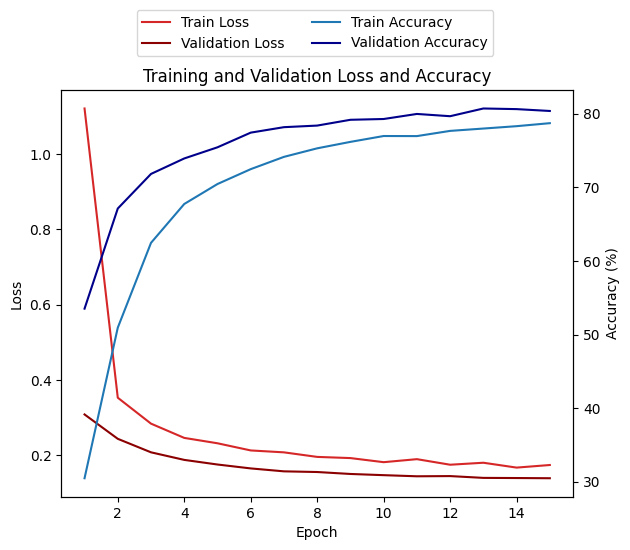

In [ ]:
model.load_state_dict(torch.load('model.pt', weights_only=False))
model.eval()

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(range(1, n_epoch + 1), train_loss_values, label='Train Loss', color=color)
ax1.plot(range(1, n_epoch + 1), validation_loss_values, label='Validation Loss', color='darkred')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Accuracy (%)')
ax2.plot(range(1, n_epoch + 1), train_accuracy_values, label='Train Accuracy', color=color)
ax2.plot(range(1, n_epoch + 1), validation_accuracy_values, label='Validation Accuracy', color='darkblue')
ax2.tick_params(axis='y')

fig.tight_layout()
plt.title("Training and Validation Loss and Accuracy")
plt.figlegend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.show()

As can be observed by the very low validation loss and high accuracy, the model performs well. The discrepancy between the training and validation values as well as the high fluctuations in the training loss and accuracy are caused by the (rather aggressive) dropout probability value used. It's a great way however to avoid overfitting.

Let's now run the model on the testing dataset.

In [ ]:
def test_model(model, device, loader):
  model.eval()

  n_epoch = 1
  best_validation_loss = float('inf')

  predictions = []
  expected = []
  for epoch in range(n_epoch):
    features, labels = next(iter(loader))

    for idx in range(batch_size):
      prediction = model(features[idx])
      predictions.append(prediction)

      expected.append(labels[idx])

  test_results = []
  for idx, sentence_prediction in enumerate(predictions):
    sentence_prediction = sentence_prediction.argmax(dim = 1, keepdim = True)
    sentence_actual = labels[idx].argmax(dim = 1, keepdim = True)

    for char_idx, character_prediction in enumerate(sentence_prediction):
      if(sentence_actual[char_idx].item() == 0 or character_prediction.item() == 0):
        continue

      test_results.append((character_prediction.item(), sentence_actual[char_idx].item()))

  return predictions, expected, test_results

predictions, expected, test_results = test_model(model, device, test_loader)

Let's now fine-tune the model's hyperparameters with a grid search.

In [ ]:
def fine_tune():
  learning_rates = [0.1, 0.01, 0.001]
  batch_sizes = [8, 16, 32, 64, 128]
  dropout_rates = [0.2, 0.4, 0.5]

  loss_results = np.zeros(shape=(len(learning_rates), len(batch_sizes)))

  for idx, lr in enumerate(learning_rates):
    for jdx, bs in enumerate(batch_sizes):
      batch_size = bs
      validate_loader.batch_size = bs

      optimizer.lr = lr

      test_model(model, device, validate_loader)

      model


Let's now generate a confusion matrix to see which values the model struggles the most with.

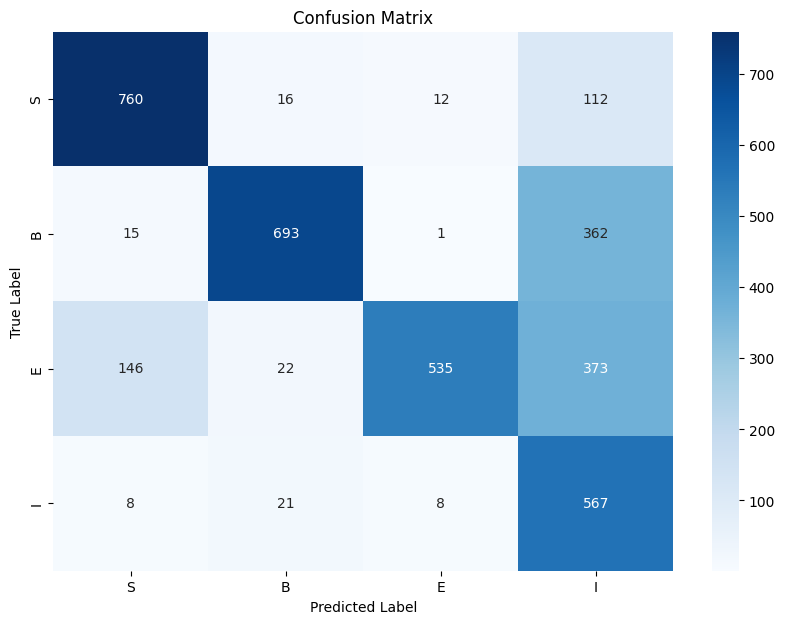

In [ ]:
predictions = [result[0] for result in test_results]
actual_values = [result[1] for result in test_results]

cm = confusion_matrix(actual_values, predictions)

categories = ['S', 'B', 'E', 'I']

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(len(categories)) + 0.5, labels=categories)
plt.yticks(ticks=np.arange(len(categories)) + 0.5, labels=categories)
plt.show()

From this, we can derive ...


In [ ]:
def tokenize_sentence(model, device, sentence):
  model.eval()

  character_vectors = generate_character_vectors(sentence)

  embedding_vectors = []
  for vector in character_vectors:
    embedding_vectors.append(vector.get_embeddings())

  predictions = model(torch.tensor(embedding_vectors, dtype=torch.float32).to(device))
  predictions = predictions.argmax(dim = 1, keepdim = True)

  tokenized_sentence = ""
  for idx, character in enumerate(sentence):
    tokenized_sentence += character
    if predictions[idx].item() == 1 or predictions[idx].item() == 3:
      tokenized_sentence += ' '

  return tokenized_sentence

print("早くも６巻が待ち遠しい。 -> ", tokenize_sentence(model, device, '早くも６巻が待ち遠しい。'))
print("長所は、自分はカッコ悪いということを、認めることができたところです -> ", tokenize_sentence(model, device, '長所は、自分はカッコ悪いということを、認めることができたところです'))
print("世界の神話を広く浅く紹介している本 -> ", tokenize_sentence(model, device, '世界の神話を広く浅く紹介している本'))
print("ひまわりは日光を好むので、鉢を日向に置いて育てるのが良い -> ", tokenize_sentence(model, device, 'ひまわりは日光を好むので、鉢を日向に置いて育てるのが良い'))
print("わたしはあなたのともだちじゃありませんよ -> ", tokenize_sentence(model, device, 'わたしはあなたのともだちじゃありませんよ'))